In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, Optional, Any

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV

Loading Data

In [42]:
def load_house_prices_local(csv_path: str) -> Tuple[pd.DataFrame, pd.Series]:
    df = pd.read_csv(csv_path)
    y = df["House_Price"]
    X = df.drop(columns=["House_Price"])
    return X, y

In [40]:
def load_parkinsons_telemonitoring(target: str = "total_UPDRS") -> Tuple[pd.DataFrame, pd.Series]:
    
    from ucimlrepo import fetch_ucirepo

    ds = fetch_ucirepo(id=189)
    X = ds.data.features.copy()
    y_df = ds.data.targets.copy()

    if target not in y_df.columns:
        raise ValueError(f"target must be one of {list(y_df.columns)}")

    y = y_df[target].copy()
    return X, y


In [41]:
def load_auto_mpg() -> Tuple[pd.DataFrame, pd.Series]:
    from ucimlrepo import fetch_ucirepo

    ds = fetch_ucirepo(id=9)
    df = pd.concat([ds.data.features.copy(), ds.data.targets.copy()], axis=1)

    df = df.replace("?", np.nan)

    for col in ["car_name", "car name", "name"]:
        if col in df.columns:
            df = df.drop(columns=[col])

    if "horsepower" in df.columns:
        df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

    if "origin" in df.columns:
        df["origin"] = df["origin"].astype("category")

    y = df["mpg"].astype(float)
    X = df.drop(columns=["mpg"])

    return X, y


Lasso


In [37]:
class LassoResult:
    name: str
    alpha: float
    metrics: Dict[str, float]
    model: Pipeline
    coef: pd.Series


In [38]:
def _build_lasso_pipeline(
    *,
    cv_folds: int = 5,
    random_state: int = 42,
    alphas: Optional[np.ndarray] = None,
    max_iter: int = 50_000,
) -> Pipeline:
    if alphas is None:
        alphas = np.logspace(-4, 2, 120)

    numeric_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    pre = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, selector(dtype_include=np.number)),
            ("cat", categorical_pipe, selector(dtype_exclude=np.number)),
        ],
        remainder="drop",
    )

    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    model = Pipeline(
        steps=[
            ("pre", pre),
            ("lasso", LassoCV(alphas=alphas, cv=cv, random_state=random_state, max_iter=max_iter, n_jobs=-1)),
        ]
    )
    return model



In [39]:
def _fit_one_dataset(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    name: str,
    test_size: float = 0.20,
    cv_folds: int = 5,
    random_state: int = 42,
    alphas: Optional[np.ndarray] = None,
    max_iter: int = 200_000,  # bumped to help convergence
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    pipe = _build_lasso_pipeline(
        cv_folds=cv_folds, random_state=random_state, alphas=alphas, max_iter=max_iter
    )
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = float(np.sqrt(mse))
    r2 = float(r2_score(y_test, preds))

    chosen_alpha = float(pipe.named_steps["lasso"].alpha_)

    pre = pipe.named_steps["pre"]
    feature_names = pre.get_feature_names_out()
    coef_vals = pipe.named_steps["lasso"].coef_
    coef = pd.Series(coef_vals, index=feature_names).sort_values(key=np.abs, ascending=False)

    return {
        "name": name,
        "alpha": chosen_alpha,
        "metrics": {"rmse": rmse, "mse": float(mse), "r2": r2},
        "model": pipe,
        "coef": coef
    }


In [44]:
def fit_3_lasso_models_8020(
    *,
    house_prices_csv_path: str,
    parkinsons_target: str = "total_UPDRS",
    test_size: float = 0.20,
    cv_folds: int = 5,
    random_state: int = 42,
    alphas: Optional[np.ndarray] = None,
    max_iter: int = 200_000,
):
    datasets = {
        "parkinsons_telemonitoring": load_parkinsons_telemonitoring(target=parkinsons_target),
        "auto_mpg": load_auto_mpg(),
        "house_prices": load_house_prices_local(house_prices_csv_path),
    }

    results = {}
    for name, (X, y) in datasets.items():
        results[name] = _fit_one_dataset(
            X, y,
            name=name,
            test_size=test_size,
            cv_folds=cv_folds,
            random_state=random_state,
            alphas=alphas,
            max_iter=max_iter,
        )
    return results

In [46]:
results = fit_3_lasso_models_8020(
    house_prices_csv_path="house_price_regression_dataset.csv",
    parkinsons_target="total_UPDRS",
    cv_folds=10,
    random_state=7
)

for name, res in results.items():
    print(f"\n=== {name} ===")
    print("alpha:", res["alpha"])
    print("metrics:", res["metrics"])
    print(res["coef"].head(15))


=== parkinsons_telemonitoring ===
alpha: 0.04186477288289951
metrics: {'rmse': 9.665827553057508, 'mse': 93.4282222854457, 'r2': 0.19479696927713153}
num__age              2.598629
num__HNR             -2.209256
num__DFA             -2.042418
num__Jitter(Abs)     -1.708180
num__PPE              1.464644
num__Jitter:RAP       1.275289
num__Shimmer:APQ3    -1.046496
num__sex             -1.036010
num__Shimmer:APQ11    0.983198
num__Shimmer:APQ5    -0.899996
num__test_time        0.852573
num__NHR             -0.802407
num__RPDE             0.624487
num__Jitter:DDP       0.010779
num__Shimmer:DDA     -0.007986
dtype: float64

=== auto_mpg ===
alpha: 0.01857409074638572
metrics: {'rmse': 3.564053223171307, 'mse': 12.702475377597784, 'r2': 0.7328486470864642}
num__weight         -5.411006
num__model_year      2.928404
cat__origin_1       -2.468875
num__displacement    1.688193
num__cylinders      -0.859807
num__horsepower     -0.318019
cat__origin_3        0.272459
num__acceleration    0.0

Ridge

In [48]:
def _build_ridge_pipeline(
    *,
    cv_folds: int = 5,
    alphas: Optional[np.ndarray] = None,
) -> Pipeline:
    if alphas is None:
        alphas = np.logspace(-3, 4, 120)

    pre = _build_lasso_pipeline(cv_folds=cv_folds).named_steps["pre"]

    return Pipeline(
        steps=[
            ("pre", pre),
            ("ridge", RidgeCV(alphas=alphas, cv=cv_folds)),
        ]
    )



In [49]:
def _fit_one_dataset_ridge(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    name: str,
    test_size: float = 0.20,
    cv_folds: int = 5,
    random_state: int = 42,
    alphas: Optional[np.ndarray] = None,
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    pipe = _build_ridge_pipeline(cv_folds=cv_folds, alphas=alphas)
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = float(np.sqrt(mse))
    r2 = float(r2_score(y_test, preds))

    chosen_alpha = float(pipe.named_steps["ridge"].alpha_)

    pre = pipe.named_steps["pre"]
    feature_names = pre.get_feature_names_out()
    coef_vals = pipe.named_steps["ridge"].coef_
    coef = pd.Series(coef_vals, index=feature_names).sort_values(key=np.abs, ascending=False)

    return {
        "name": name,
        "alpha": chosen_alpha,
        "metrics": {"rmse": rmse, "mse": float(mse), "r2": r2},
        "model": pipe,
        "coef": coef,
    }


In [50]:
def fit_3_ridge_models_8020(
    *,
    house_prices_csv_path: str,
    parkinsons_target: str = "total_UPDRS",
    test_size: float = 0.20,
    cv_folds: int = 5,
    random_state: int = 42,
    alphas: Optional[np.ndarray] = None,
):
    datasets = {
        "parkinsons_telemonitoring": load_parkinsons_telemonitoring(target=parkinsons_target),
        "auto_mpg": load_auto_mpg(),
        "house_prices": load_house_prices_local(house_prices_csv_path),
    }

    results = {}
    for name, (X, y) in datasets.items():
        results[name] = _fit_one_dataset_ridge(
            X, y,
            name=name,
            test_size=test_size,
            cv_folds=cv_folds,
            random_state=random_state,
            alphas=alphas,
        )
    return results

In [51]:
ridge_results = fit_3_ridge_models_8020(
    house_prices_csv_path="house_price_regression_dataset.csv",
    parkinsons_target="total_UPDRS",
    cv_folds=10,
    random_state=7
)

for name, res in ridge_results.items():
    print(f"\n=== {name} (Ridge) ===")
    print("alpha:", res["alpha"])
    print("metrics:", res["metrics"])
    print(res["coef"].head(15))


=== parkinsons_telemonitoring (Ridge) ===
alpha: 76.26985859023436
metrics: {'rmse': 9.664831569620185, 'mse': 93.40896926912697, 'r2': 0.19496289972845737}
num__age              2.575320
num__HNR             -2.259235
num__DFA             -2.096406
num__Jitter(Abs)     -1.969764
num__PPE              1.524840
num__Shimmer:APQ11    1.345825
num__sex             -1.093499
num__Jitter:DDP       1.019037
num__Jitter:RAP       1.014023
num__test_time        0.894772
num__Jitter:PPQ5     -0.840821
num__Shimmer:APQ5    -0.832115
num__NHR             -0.738354
num__Shimmer:APQ3    -0.727401
num__Shimmer:DDA     -0.727090
dtype: float64

=== auto_mpg (Ridge) ===
alpha: 2.955209235202888
metrics: {'rmse': 3.584500065817462, 'mse': 12.84864072184539, 'r2': 0.7297745793709947}
num__weight         -5.075937
num__model_year      2.887127
cat__origin_1       -1.777558
num__displacement    1.741050
cat__origin_3        1.101550
num__cylinders      -1.055343
cat__origin_2        0.676007
num__horsepo

In [53]:
def plot_model_results(results_dict, *, top_k=15):
    for name, res in results_dict.items():
        model = res["model"]

        if name == "parkinsons_telemonitoring":
            X, y = load_parkinsons_telemonitoring(target="total_UPDRS")
        elif name == "auto_mpg":
            X, y = load_auto_mpg()
        elif name == "house_prices":
            X, y = load_house_prices_local("house_price_regression_dataset.csv")
        else:
            continue

        y_pred = model.predict(X)

        plt.figure()
        plt.scatter(y, y_pred)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{name}: Actual vs Predicted (R2={res['metrics']['r2']:.3f})")
        plt.show()

        coef = res["coef"]
        top = coef.reindex(coef.abs().sort_values(ascending=False).head(top_k).index)

        plt.figure()
        plt.bar(range(len(top)), top.values)
        plt.xticks(range(len(top)), top.index, rotation=90)
        plt.ylabel("Coefficient")
        plt.title(f"{name}: Top {top_k} Coefficients")
        plt.tight_layout()
        plt.show()

Results

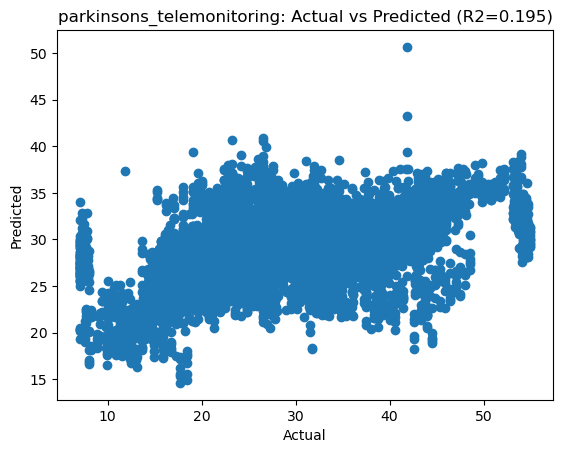

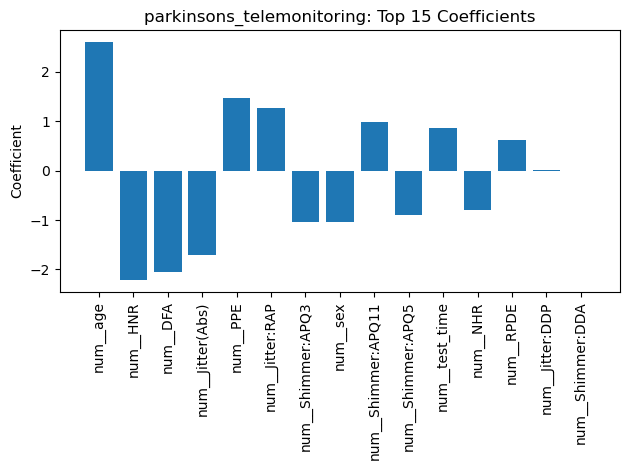

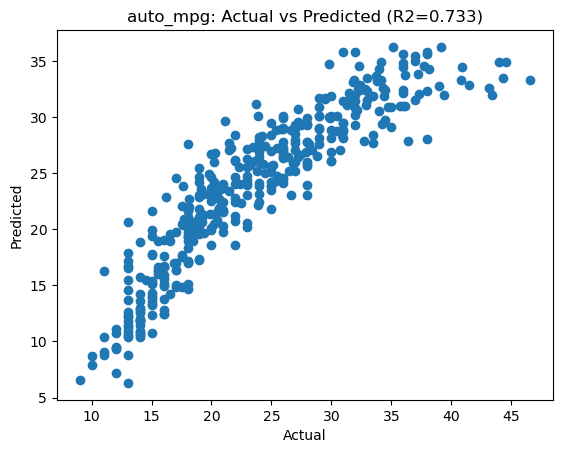

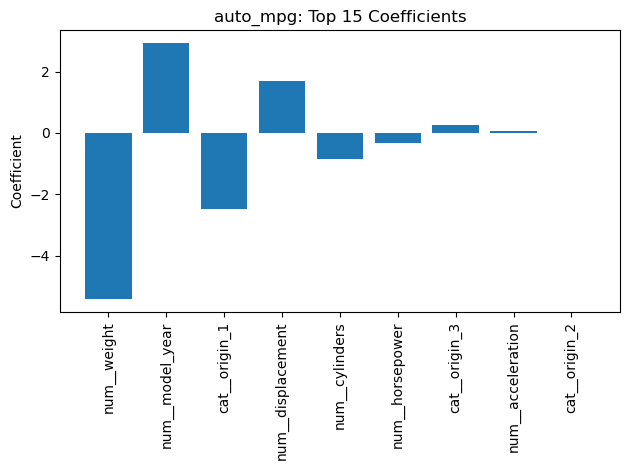

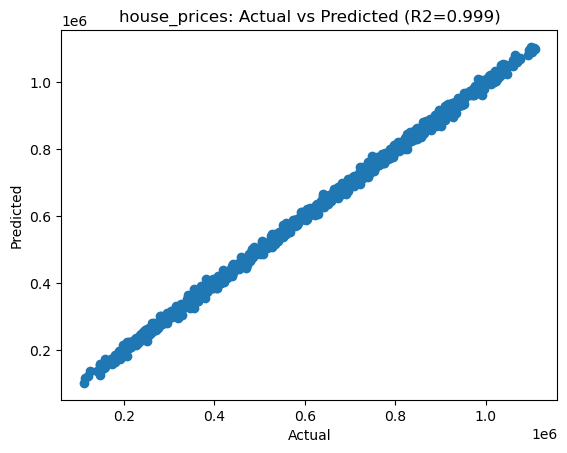

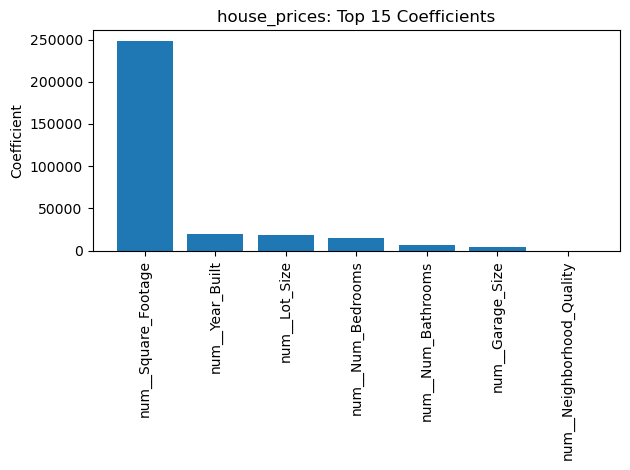

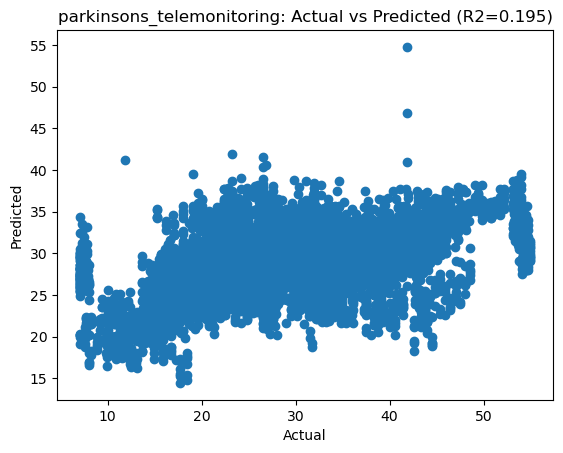

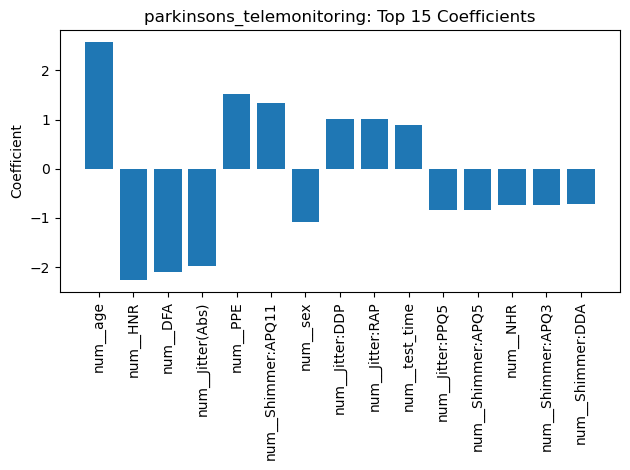

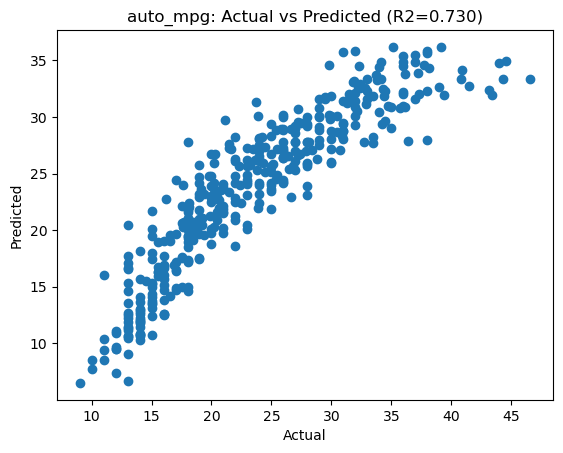

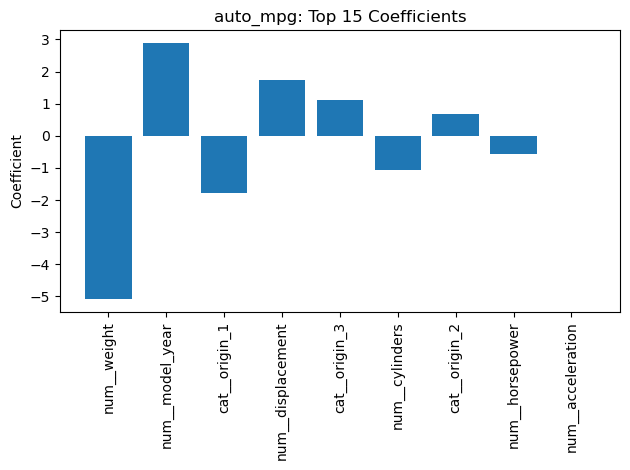

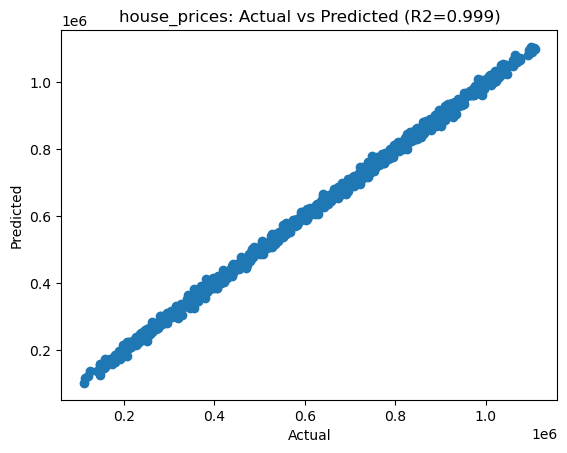

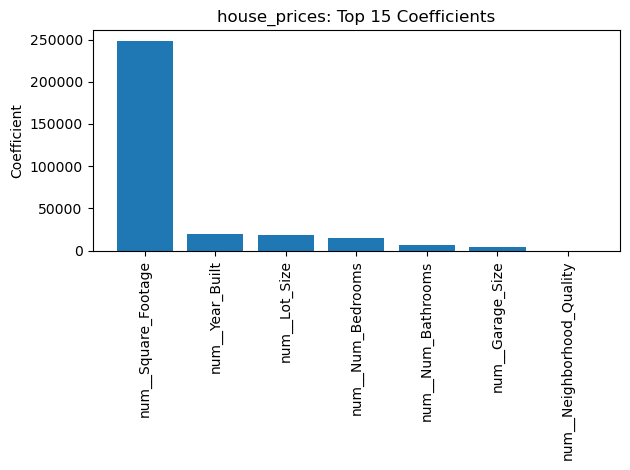

In [55]:
plot_model_results(results, top_k=15)
plot_model_results(ridge_results, top_k=15)
